In [190]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import math
from scipy.fftpack import fft2, fftshift
from collections import Counter



def crop_image_contour_sorry_kiwi(img_gray): 
    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)

    # Apply binary thresholding
    _, binary_img = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological closing to merge nearby bars
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # Adjust kernel size if needed
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    contour_img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)  # Convert to color for visualization
    cv2.rectangle(contour_img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Adjust the bounding box to shift left and right
    shifted_x = x - 1  # Shift left by 1 pixel
    shifted_w = w + 1  # Increase width by 1 pixel to compensate

    # Ensure the coordinates don't go out of bounds (optional)
    shifted_x = max(0, shifted_x)  # Ensure x doesn't go below 0
    shifted_w = min(img_gray.shape[1] - shifted_x, shifted_w)  # Ensure the width doesn't exceed the image width

    # Crop the image with the adjusted bounding box
    cropped_barcode = img_gray[y:y+h, shifted_x:shifted_x+shifted_w]
    # Display the original image and cropped barcode
    # plt.imshow(cropped_barcode, cmap='gray')
    # plt.title("Cropped Barcode"), plt.axis('off')

    bottom_pixels=10
    top_pixels=10

    # Calculate new dimensions
    height, width = cropped_barcode.shape[:2]
    cropped_image = cropped_barcode[top_pixels:height-bottom_pixels, :]
    
    return cropped_image

  
def threshold_image(image,threshold_value,max_value):
    #every pixel that has value greater than or equal threshold_value, will be set to max_value, otherwise the pixel will be zero (black)
    _, thresholded_image = cv2.threshold(image, threshold_value, max_value, cv2.THRESH_BINARY)
    return thresholded_image

def sobel_edge_detection(image):
    # Add 3 pixels of white padding around the image
    padded_image = cv2.copyMakeBorder(image, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=255)
    
    # Perform Sobel edge detection on the padded image
    sobel_x = cv2.Sobel(padded_image, cv2.CV_64F, 1, 0, ksize=3)  
    sobel_y = cv2.Sobel(padded_image, cv2.CV_64F, 0, 1, ksize=3) 
    edges = cv2.magnitude(sobel_x, sobel_y)
    edges = cv2.convertScaleAbs(edges)
    
    # Remove the padding from the edge-detected image
    final_edges = edges[3:-3, 3:-3]
    
    return final_edges


def display_image(img,title=''):
        plt.figure(figsize=(8, 6))  
        plt.imshow(img,cmap='gray')
        plt.axis('off') 
        plt.title(title)
        plt.show()


def show_frequency_domain(image,title=''):
    # Perform Fourier Transform
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift zero frequency component to the center
    # Compute magnitude spectrum
    magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    magnitude_spectrum = 20 * np.log1p(magnitude)  # Log scale for better visibility

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray')
    plt.title('Original Image'), plt.axis('off')
    plt.subplot(1, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Frequency Domain'+title), plt.axis('off')
    plt.show()


def find_threshold_value(img_gray):
    
    hist_counts, bin_edges = np.histogram(img_gray.ravel(), bins=64, range=(0, 256))
    
    # Total number of pixels in the image
    total_pixels = img_gray.size
    
    # Calculate the number of pixels in the dark region (0 to 127)
    dark_pixels = np.sum(hist_counts[:32])  # The first 32 bins correspond to pixel values from 0 to 127

    # Calculate the number of pixels in the bright region (128 to 255)
    bright_pixels = np.sum(hist_counts[32:])  # The remaining 32 bins correspond to pixel values from 128 to 255

    # Calculate the percentage of dark and bright pixels
    dark_percentage = dark_pixels / total_pixels
    bright_percentage = bright_pixels / total_pixels

    # Get indices of the top 5 bins with the highest counts, excluding zero bins
    non_zero_indices = np.where(hist_counts > 0)[0] 
    top_5_indices = np.argsort(hist_counts[non_zero_indices])[-5:][::-1]  
    top_5_bins = [bin_edges[non_zero_indices[i]] for i in top_5_indices]

    # print(f"Top 5 bins: {top_5_bins}")

    # Calculate the simple average of the top 5 bins

    # Tried weighted average first but this is better apparently and kinda makes sense
    top_5_values = [np.mean([bin_edges[non_zero_indices[i]], bin_edges[non_zero_indices[i] + 1]]) for i in top_5_indices]

    # Compute the simple average of the top 5 bins
    average = np.mean(top_5_values)
    # print(f"Average of the top 5 bins: {average}")

    # Check if bins are concentrated near 128 (contrast issues)
    contrast_bin_range = (120, 160)  # Define a range around 128
    contrast_bins = np.sum(hist_counts[np.logical_and(bin_edges[:-1] >= contrast_bin_range[0], bin_edges[:-1] < contrast_bin_range[1])])
    contrast_percentage = contrast_bins / total_pixels
    return math.floor(average)



def compute_histogram(img_gray, bins=64):
    # Compute histogram and bin edges
    hist_counts, bin_edges = np.histogram(img_gray.ravel(), bins=bins, range=(0, 256))
    total_pixels = img_gray.size
    return hist_counts, bin_edges, total_pixels

def detect_dark(hist_counts, bin_edges, total_pixels, threshold=0.8):
    # Calculate the number of dark pixels (0 to 127)
    dark_pixels = np.sum(hist_counts[:32])  # The first 32 bins correspond to pixel values from 0 to 127
    dark_percentage = dark_pixels / total_pixels
    
    if dark_percentage > threshold:
        print("The image is biased towards dark (0) regions.")
        return True
    return False 

def detect_bright(hist_counts, bin_edges, total_pixels, threshold=0.95):
    # Calculate the number of bright pixels (128 to 255)
    bright_pixels = np.sum(hist_counts[32:])  # The remaining 32 bins correspond to pixel values from 128 to 255
    bright_percentage = bright_pixels / total_pixels
    
    if bright_percentage > threshold:
        print("The image is biased towards bright (255) regions.")
        return True
    return False

def detect_contrast(hist_counts, bin_edges, total_pixels, contrast_range=(120, 160), threshold=0.4):
    # Check if bins are concentrated near 128 (contrast issues)
    contrast_bins = np.sum(hist_counts[np.logical_and(bin_edges[:-1] >= contrast_range[0], bin_edges[:-1] < contrast_range[1])])
    contrast_percentage = contrast_bins / total_pixels
    
    if contrast_percentage > threshold:
        print("The image likely has contrast issues with pixel values concentrated around 128.")
        return True
    return False

# def find_threshold_value(img_gray):
#     # Step 1: Compute histogram data
#     hist_counts, bin_edges, total_pixels = compute_histogram(img_gray)
    

#     #     non_zero_indices = np.where(hist_counts > 0)[0] 
#     top_5_indices = np.argsort(hist_counts[non_zero_indices])[-5:][::-1]  
#     top_5_bins = [bin_edges[non_zero_indices[i]] for i in top_5_indices]

# #     # print(f"Top 5 bins: {top_5_bins}")

#      # Calculate the simple average of the top 5 bins

#      # Tried weighted average first but this is better apparently and kinda makes sense
#     top_5_values = [np.mean([bin_edges[non_zero_indices[i]], bin_edges[non_zero_indices[i] + 1]]) for i in top_5_indices]

#      # Compute the simple average of the top 5 bins
#     average = np.mean(top_5_values)
#     # print(f"Average of the top 5 bins: {average}")
#     # Step 2: Check for dark, bright, and contrast issues
#     # if detect_dark(hist_counts, bin_edges, total_pixels):
#     #     return math.floor(np.mean([np.mean([bin_edges[i], bin_edges[i+1]]) for i in range(5)]))  # Dark-biased image threshold

#     # if detect_bright(hist_counts, bin_edges, total_pixels):
#     #     return math.floor(np.mean([np.mean([bin_edges[i], bin_edges[i+1]]) for i in range(5)]))  # Bright-biased image threshold

#     # if detect_contrast(hist_counts, bin_edges, total_pixels):
#     #     return math.floor(np.mean([np.mean([bin_edges[i], bin_edges[i+1]]) for i in range(5)]))  # Contrast-biased image threshold
    
#     # If no special conditions, calculate average of the top 5 bins
#     non_zero_indices = np.where(hist_counts > 0)[0]
#     top_5_indices = np.argsort(hist_counts[non_zero_indices])[-5:][::-1]
#     top_5_values = [np.mean([bin_edges[non_zero_indices[i]], bin_edges[non_zero_indices[i] + 1]]) for i in top_5_indices]
    
#     average = np.mean(top_5_values)
#     # print("The image has a balanced distribution of dark and bright regions.")
#     return math.floor(average)


def mask_freq(image,horizontal,vertical):
    # Perform Fourier Transform to convert the image to frequency domain
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift zero frequency to the center

    # Get the magnitude spectrum for visualization
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    # Create a mask to retain horizontal and vertical frequencies
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the frequency domain

    # Initialize the mask
    mask = np.zeros((rows, cols, 2), np.uint8)

    # Retain a cross-shaped region (horizontal and vertical lines) in the frequency domain
    bandwidth = 1  # Adjust the width of the horizontal and vertical frequency bands
    if horizontal:
        mask[crow-bandwidth:crow+bandwidth, :] = 1  # Horizontal band
    if vertical:
        mask[:, ccol-bandwidth:ccol+bandwidth] = 1  # Vertical band

    # Apply the mask to the frequency domain
    filtered_dft = dft_shift * mask

    # Shift back and inverse Fourier Transform to return to the spatial domain
    filtered_dft_shift = np.fft.ifftshift(filtered_dft)
    filtered_image = cv2.idft(filtered_dft_shift)
    filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

    # Normalize the filtered image for better visualization
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)

    filtered_image=threshold_image(filtered_image,100,255)
    
    return filtered_image



def houghTransform(image):
    edge_detection=sobel_edge_detection(image)

    lines = cv2.HoughLinesP(edge_detection, 1, np.pi / 180, threshold=80, minLineLength=30, maxLineGap=200)

    # Create a copy of the thresholded_edges image to draw the lines
    final_image = edge_detection.copy()

    # Draw the lines on the thresholded_edges image with thinner lines
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Calculate the angle of the line
            angle = np.arctan2(y2 - y1, x2 - x1)
            # Exclude horizontal lines by checking if the angle is near 0 or π
            if abs(angle) > np.pi / 6:  # Threshold to avoid nearly horizontal lines (e.g., 10 degrees)
                cv2.line(final_image, (x1, y1), (x2, y2), (255), 1)  # Draw with thinner lines (thickness=1)



    contours, _ = cv2.findContours(final_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_image = np.zeros_like(final_image)

    # Fill the contours (regions inside the bars) with white
    cv2.drawContours(filled_image, contours, -1, (255), thickness=cv2.FILLED)
    cv2.drawContours(filled_image, contours, -1, (0), thickness=1) #remove contour



    # Invert the image if needed
    inverted_image = cv2.bitwise_not(filled_image)

    inverted_image=crop_image_contour_sorry_kiwi(inverted_image)
    return inverted_image




def is_horizontal_sinc(image):
     # Step 1: Compute the 2D FFT of the image
    frequency_domain = fftshift(fft2(image))
    
    # Step 2: Get the magnitude spectrum
    magnitude_spectrum = np.abs(frequency_domain)
    
    # Step 3: Find the center of the spectrum
    center_y, center_x = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
    
    # Step 4: Analyze the spectrum
    # Horizontal sinc means energy should be concentrated along the center row (y=center_y)
    row_energy = magnitude_spectrum[center_y, :]
    col_energy = magnitude_spectrum[:, center_x]
    
    # A horizontal sinc would have significant energy in the center row and less in the center column
    row_energy_sum = np.sum(row_energy)
    col_energy_sum = np.sum(col_energy)
    
    # We consider it horizontal sinc if the row energy is significantly higher than column energy
    if row_energy_sum > col_energy_sum * 10:  # Adjust the threshold as needed
        # Ensure no other significant peaks in the spectrum
        other_energy = np.sum(magnitude_spectrum) - row_energy_sum
        if other_energy < row_energy_sum * 0.1:  # Allow some tolerance for noise
            return True
    
    return False







def rotate_img(img,angle):

    #Find the center of the image and rotate based on it with the angle detected before-hand
    #Form the rotation matrix
    # -(angle) so we can revert the angle of the rotation
    #180 - angle because the angles detected are second quadrant

    center = (img.shape[1] // 2, img.shape[0] // 2)

    rot_matrix = cv2.getRotationMatrix2D(center,-(180-angle) , 1.0)

    rotated_img = cv2.warpAffine(img, rot_matrix, (img.shape[1], img.shape[0]))

    return rotated_img


def find_angle(img_gray):

    #Find the hough transform of the image
    #run canny detector since hough works on edges 
    #find the most dominant line angle
    #display the 5 most common angles for analysis
    #return the most common or second most as explained

    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)
    
    edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    angles = []

    if lines is not None:
        for rho, theta in lines[:, 0]:
            angle = np.degrees(theta)  
            angles.append(angle)  
         
    if angles:
        
        angle_counts = Counter(angles)
        
        
        top_5_angles = angle_counts.most_common(5)
        
        
        print("\nTop 5 most repeated angles:")
        for angle, count in top_5_angles:
    
            print(f"Angle: {angle:.2f} degrees, Count: {count}")

    if top_5_angles[0][0] == 45.00:
        return top_5_angles[1][0]  # Return the second most common angle
    else:
        return top_5_angles[0][0]  # Return the most common angle
    

    





def check_disconnected_vertical_lines(image):   
    # Detect vertical lines by summing pixel values along rows (columns)
    vertical_projection = np.sum(image, axis=0)
    
    # Check for disconnected vertical lines (gaps in the projection)
    disconnected_vertically = np.any(vertical_projection == 0)
    
    # Return True if disconnected vertical lines exist
    return disconnected_vertically




def detect_salt_pepper_noise(image, high_freq_threshold=0.5, energy_ratio_threshold=0.05):
    """
    Detects excessive salt-and-pepper noise in an image using the frequency domain.

    Parameters:
    - image: Grayscale image as a 2D NumPy array.
    - high_freq_threshold: Threshold for high-frequency regions (as a proportion of the maximum frequency).
    - energy_ratio_threshold: Threshold for high-frequency energy ratio to detect noise.

    Returns:
    - True if the image is excessively noisy, otherwise False.
    """
    # Compute the 2D Fourier Transform and shift the zero-frequency component to the center
    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shifted)
    
    # Define high-frequency region
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    radius = int(min(rows, cols) * high_freq_threshold)
    
    # Create a mask for high frequencies
    y, x = np.ogrid[:rows, :cols]
    high_freq_mask = ((x - ccol)**2 + (y - crow)**2) > radius**2
    
    # Calculate energy ratio
    total_energy = np.sum(magnitude_spectrum**2)
    high_freq_energy = np.sum(magnitude_spectrum[high_freq_mask]**2)
    energy_ratio = high_freq_energy / total_energy if total_energy > 0 else 0
    
    # Return if the noise level exceeds the threshold
    return energy_ratio > energy_ratio_threshold


def fill_corners(rotated_img):
    
    filled_image = rotated_img.copy()

    
    h, w = filled_image.shape
    flood_fill_color = 255  

    # Create a mask for flood fill (2 pixels larger than the image)
    mask = np.zeros((h + 2, w + 2), np.uint8)

   
    cv2.floodFill(filled_image, mask, seedPoint=(0, 0), newVal=flood_fill_color)  # Top-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, 0), newVal=flood_fill_color)  # Top-right corner
    cv2.floodFill(filled_image, mask, seedPoint=(0, h - 1), newVal=flood_fill_color)  # Bottom-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, h - 1), newVal=flood_fill_color)  # Bottom-right corner

    

    return filled_image

def perform_closing(binary_img, kernel_width=4, kernel_height=180):
    # Create a rectangular structuring element with a width of 4 pixels and height large enough to fill the gap
    kernel = np.ones((kernel_height, kernel_width), np.uint8)  # Vertical kernel to connect larger gaps
    
    # Perform closing operation (dilation followed by erosion)
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    
    return closed_img



def get_mean_pixels(cropped_barcode,n):
    
    cropped_barcode = cropped_barcode.astype(np.uint8)

    # Get the mean of the first `n` pixels vertically for each column
    mean = cropped_barcode[-n:, :].mean(axis=0)
        # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    
    

        # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    while pixels and pixels[0] == '0':
        pixels = pixels[1:]



    print(pixels)
    return pixels



  # 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
 "00110": "Stop/Start",
 "10001": "1",
 "01001": "2",
 "11000": "3",
 "00101": "4",
 "10100": "5",
 "01100": "6",
 "00011": "7",
 "10010": "8",
 "10000": "9",
 "00001": "0",
 "00100": "-",
}

def get_code(pixels):
    # Determine how many pixels represent a narrow bar
    n = 0
    for pixel in pixels:
        if pixel == "1":
            n += 1
        else:
            break

    # Define narrow and wide bar sizes with ±1 tolerance
    narrow_bar_size = range(n-1, n+2)  # Includes n±1
    wide_bar_size = range(n*2-1, n*2+2)  # Includes n*2±1

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):
        if skip_next:
            pixel_index += n  # Skip the separator bar
            skip_next = False
            continue

        # Count consecutive pixels of the same value
        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except IndexError:
            pass
        pixel_index += 1

        # Determine if the width matches narrow or wide
        if count in narrow_bar_size:
            current_digit_widths += NARROW
            
        elif count in wide_bar_size:
            current_digit_widths += WIDE

        else:
            print(digits)
            print(f"Unexpected bar width: {count}")
            return None

        # Check if the current widths match a valid digit
        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Skip the separator bar next iteration

    print(digits)
    return digits

def variance_of_laplacian(image):
	return cv2.Laplacian(image, cv2.CV_64F).var()


def decode_barcode(pic):
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in the image
    mean = pic.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    
    while pixels and pixels[0] == '0':
        pixels = pixels[1:]

    print(pixels)

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    tolerance = 1  # Allow for tolerance of +1 and -1 on the narrow bar size

    while pixel_index < len(pixels):
        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        # Check if the count matches narrow or wide bar size with a tolerance of +1 or -1
        if (count == narrow_bar_size) or (count == narrow_bar_size + tolerance) or (count == narrow_bar_size - tolerance):
            current_digit_widths += NARROW
        elif (count == wide_bar_size) or (count == wide_bar_size + tolerance) or (count == wide_bar_size - tolerance):
            current_digit_widths += WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    # Check if digits were decoded and print the barcode value
    if digits:
        
        print(f"Decoded barcode value: {digits}")
        return True
    else:
        print("Failed to decode the barcode.")
        return False





In [191]:
def function():
    flag 
    

In [61]:
%pip install scikit-learn 

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.1 MB 1.3 MB/s eta 0:00:09
    --------------------------------------- 0.2/11.1 MB 1.8 MB/s eta 0:00:07
   - -------------------------------------- 0.3/11.1 MB 1.8 MB/s eta 0:00:07
   - -------------------------------------- 0.5/11.1 MB 2.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.7/11.1 MB 2.6 MB/s eta 0:00:05
   -- ------------------------------------- 0.8/11.1 MB 2.6 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/11.1 MB 2.7 MB/s eta 0:00:04
   ---- ----------------------------------- 1.1/11.1 MB 2.9 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/11.1 MB 3.0 MB/s eta 0:00:04
   ----- --------------------------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd

from collections import Counter



img_gray3=cv2.imread('TestCases/ 11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE) 

dft_img = np.fft.fft2(img_gray3)  # Assuming img_gray is the grayscale barcode image
dft_shift = np.fft.fftshift(dft_img)
magnitude_spectrum = np.log(np.abs(dft_shift))


plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.show()
_, thresh = cv2.threshold(magnitude_spectrum, 10, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Spectrum')
plt.show()



# Apply Canny edge detection
edges = cv2.Canny(img_gray3, 50, 150, apertureSize=3)

# Apply Hough Line Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

plt.imshow(edges,cmap='gray')
import pandas as pd

# Convert the amplitude spectrum array to a DataFrame
magnitude_df = pd.DataFrame(magnitude_spectrum)

# Flatten the DataFrame and get the top 10 values
top_10_amplitudes = magnitude_df.values.flatten()  # Flatten to a 1D array
top_10_values = pd.Series(top_10_amplitudes).nlargest(10)

# Print top 10 amplitudes
print(top_10_values)


threshold = 14.05 # Set your desired amplitude threshold
filtered_dft = dft_shift.copy()
filtered_dft[magnitude_spectrum > threshold] = 0  # Zero out high-amplitude frequencies

# Step 5: Inverse shift and inverse DFT
filtered_dft[0, 0] = dft_shift[0, 0]  # Restore the DC component after filtering

dft_img_ishift = np.fft.ifftshift(filtered_dft)
img_reconstructed = np.fft.ifft2(dft_img_ishift)
img_reconstructed = np.abs(img_reconstructed)
img_reconstructed = cv2.normalize(img_reconstructed, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(img_reconstructed, cmap='gray')






# Apply threshold to reconstructed image: values above 200 become 255, below 200 become 0
threshold_value = 140
_, binary_img = cv2.threshold(img_reconstructed, threshold_value, 255, cv2.THRESH_BINARY)

# Show the result
plt.imshow(binary_img, cmap='gray')
plt.title('Thresholded Reconstructed Image')
plt.show()


angle =find_angle(binary_img)


rotated_img=rotate_img(binary_img,angle)


_,rotated_img=cv2.threshold(rotated_img,128,255,cv2.THRESH_BINARY_INV)


#rotated_img=connect_vertical_bars(rotated_img,20)

cropped_img=crop_image_contour_sorry_kiwi(rotated_img)

# cropped_img=perform_closing(cropped_img,4,180)

display_image(cropped_img)








NameError: name 'cv2' is not defined

pipeline

In [9]:
picture_names = [
    "01 - lol easy.jpg",
    "02 - still easy.jpg",
    "03 - eda ya3am ew3a soba3ak mathazarsh.jpg",
    "04 - fen el nadara.jpg",
    "05 - meen taffa el nour!!!.jpg",
    "06 - meen fata7 el nour 333eenaaayy.jpg",
    "07 - mal7 w felfel.jpg",
    "08 - compresso espresso.jpg",
    "09 - e3del el soora ya3ammm.jpg",
    "10 - wen el kontraastttt.jpg",
    "11 - bayza 5ales di bsara7a.jpg"
]










ready_for_decoding=[]
not_ready=[]
names=[]


def phase1(): #fix lighting problems or random noise
    for pic in picture_names:
        image=cv2.imread(pic, cv2.IMREAD_GRAYSCALE) 
        org_image=image.copy()  
        image=threshold_image(image,find_threshold_value(image),255)
        image=crop_image_contour_sorry_kiwi(image)
        # if not is_horizontal_sinc(image):
        #     not_ready.append(org_image)
        # else:
        #     ready_for_decoding.append(image)
        pixels=get_mean_pixels(image,40)
        code=get_code(pixels)

        if(code):


            if(code[0]=="Stop/Start" and code[-1]=="Stop/Start"):
                ready_for_decoding.append(image)
        else:
            not_ready.append(org_image)


        

    



        
def phase2():  # Searching for salt and pepper
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image in not_ready[:]:  
        org_image = image.copy()
        if detect_salt_pepper_noise(image): 
            image = perform_closing(image)
            image = crop_image_contour_sorry_kiwi(image)
            image = mask_freq(image,True,False)
            
        # if is_horizontal_sinc(image):
        #     not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
        #     ready_for_decoding.append(image)
        # else:
        #     not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
        #     not_ready.append(image)  # Add the modified image


        pixels=get_mean_pixels(image,40)
        code=get_code(pixels)
        if(code):
                
            if(code[0]=="Stop/Start" and code[-1]=="Stop/Start"):
                not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
                ready_for_decoding.append(image)
        else:
            not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
            not_ready.append(image)
            

        


def phase3():  # angles
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image in not_ready[:]:  # Iterate over a copy of the list to avoid modifying it during iteration
        org_image = image.copy() 
        if find_angle(image) != 0:
            angle=find_angle(image)
            image=rotate_img(image,angle)
            image=fill_corners(image)
          
        # if is_horizontal_sinc(image):
        #     # Use np.array_equal to compare arrays by content
        #     not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  
        # else:
        #     # Use np.array_equal to compare arrays by content
        #     not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  
        #     not_ready.append(image)

        
        pixels=get_mean_pixels(image,40)
        code=get_code(pixels)

        if (code):

            if(code[0]=="Stop/Start" and code[-1]=="Stop/Start"):
                not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
                ready_for_decoding.append(image)
        else:
            not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
            not_ready.append(image)
            




def phase4(): # object removal
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image in not_ready[:]:  # Iterate over a copy of the list to avoid modifying it during iteration
        org_image = image.copy() 
        image = crop_image_contour_sorry_kiwi(image)
        image = mask_freq(image, True, False)
        
        if(check_disconnected_vertical_lines(image)):
              image = houghTransform(image)
        
        # if is_horizontal_sinc(image):
        #     not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
        #     ready_for_decoding.append(image)  # Add to ready_for_decoding
        # else:
        #     not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
        #     not_ready.append(image)  # Add the modified image

        pixels=get_mean_pixels(image,40)
        code=get_code(pixels)
        if(code):
                
            if( code[0]=="Stop/Start" and code[-1]=="Stop/Start"):
                not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
                ready_for_decoding.append(image)
        else:
            not_ready = [img for img in not_ready if not np.array_equal(img, org_image)]  # Remove org_image
            not_ready.append(image)
            
           
    

# image=cv2.imread("08 - compresso espresso.jpg", cv2.IMREAD_GRAYSCALE) 
# image=crop_image_contour_sorry_kiwi(image)
# image=perform_closing(image)
# image=threshold_image(image,find_threshold_value(image),255)

# display_image(image)

# final_image=image


            
    
phase1()
phase2()
phase3()
phase4()


# print('ready')
# for p in ready_for_decoding:
#     display_image(p)

print('not ready')
for p in not_ready:
    display_image(p)


11110000111111110000000011110000111111110000111100001111111100001111000000001111000011111111000011111111000000001111000011110000111100001111111100001111111100001111111100001111111100001111000011110000000011111111000011110000111100001111000000001111111100001111111100001111000000001111000011111111000011110000111100001111000011110000111111110000111100001111111100001111000011110000111111110000000011110
['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011111111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110
['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']
1111111111111111111111100000

UnboundLocalError: cannot access local variable 'top_5_angles' where it is not associated with a value

In [440]:
for pic in ready_for_decoding:
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    your_cropped_image=pic
    # Get the average of each column in your image
    mean = your_cropped_image.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

   
    print(digits)


['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']
['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']
['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']
['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']
['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']
['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']
[]


third pic

In [437]:
# image = cv2.imread('testt.png', cv2.IMREAD_GRAYSCALE)
# mean = image.mean(axis=0)

mean=final_image.mean(axis=0)

    # Set it to black or white based on its value
mean[mean <= 127] = 1
mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

print(pixels)

11111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111000011110000111100001111111100001111000011111111000011111111000011110000111100000000111100001111111100001111000011111111000011110000111100001111111


In [435]:
# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

your_cropped_image=final_image
# Get the average of each column in your image
mean = your_cropped_image.mean(axis=0)

# Set it to black or white based on its value
mean[mean <= 127] = 1
mean[mean > 128] = 0

# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

# Need to figure out how many pixels represent a narrow bar
narrow_bar_size = 0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
    else:
        break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

    if skip_next:
        pixel_index += narrow_bar_size
        skip_next = False
        continue

    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except:
        pass
    pixel_index += 1

    current_digit_widths += NARROW if count == narrow_bar_size else WIDE

    if current_digit_widths in code11_widths:
        digits.append(code11_widths[current_digit_widths])
        current_digit_widths = ""
        skip_next = True  # Next iteration will be a separator, so skip it

print(digits)

[]


In [43]:
for pic in picture_names:



    image=cv2.imread(pic,cv2.IMREAD_GRAYSCALE)

    threshold=find_threshold_value(image)







The image has a balanced distribution of dark and bright regions.
The image has a balanced distribution of dark and bright regions.
The image has a balanced distribution of dark and bright regions.
The image has a balanced distribution of dark and bright regions.
The image is biased towards dark (0) regions.
The image is biased towards bright (255) regions.
The image has a balanced distribution of dark and bright regions.
The image has a balanced distribution of dark and bright regions.
The image has a balanced distribution of dark and bright regions.
The image likely has contrast issues with pixel values concentrated around 128.
The image has a balanced distribution of dark and bright regions.


In [36]:
def generic_processing(image):

    salt_and_pepper_flag=detect_salt_pepper_noise(image)

    print(salt_and_pepper_flag)

    angle=find_angle(image)

    find_threshold_value(image)





    





In [37]:
image=cv2.imread("07 - mal7 w felfel.jpg",cv2.IMREAD_GRAYSCALE)
generic_processing(image)

True

Top 10 most repeated angles:
Angle: 135.00 degrees, Count: 333
Angle: 45.00 degrees, Count: 332
Angle: 179.00 degrees, Count: 201
Angle: 0.00 degrees, Count: 199
Angle: 58.00 degrees, Count: 190
Angle: 32.00 degrees, Count: 190
Angle: 13.00 degrees, Count: 180
Angle: 24.00 degrees, Count: 179
Angle: 11.00 degrees, Count: 179
Angle: 14.00 degrees, Count: 178
The image has a balanced distribution of dark and bright regions.


In [82]:
import numpy as np
from scipy.fftpack import fft2, fftshift

def detect_sincs_in_horizontal_strips(
    image, strip_height=20, energy_ratio_threshold=10, tolerance=0.4, min_sincs=2
):
    """
    Detects sinc-like patterns by analyzing horizontal strips of an image in the frequency domain.
    
    Parameters:
        image (numpy.ndarray): Input grayscale image.
        strip_height (int): Height of each horizontal strip.
        energy_ratio_threshold (float): Minimum ratio of energy concentration in a direction to classify as sinc-like.
        tolerance (float): Maximum allowable proportion of energy outside dominant directions.
        min_sincs (int): Minimum number of sinc-like patterns across all strips to return True.
    
    Returns:
        bool: True if more than `min_sincs` sinc-like patterns are detected across all strips, False otherwise.
        int: Total number of sinc-like patterns detected.
    """
    sinc_count = 0
    
    # Divide the image into horizontal strips
    num_strips = image.shape[0] // strip_height
    for i in range(num_strips):
        # Extract the strip
        strip = image[i * strip_height : (i + 1) * strip_height, :]
        
        # Step 1: Compute the 2D FFT of the strip
        frequency_domain = fftshift(fft2(strip))
        
        # Step 2: Get the magnitude spectrum
        magnitude_spectrum = np.abs(frequency_domain)
        
        # Step 3: Find the center of the spectrum
        center_y, center_x = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
        
        # Step 4: Analyze energy distribution
        row_energy = np.sum(magnitude_spectrum[center_y, :])  # Energy in center row
        col_energy = np.sum(magnitude_spectrum[:, center_x])  # Energy in center column
        diag1_energy = np.sum(np.diag(magnitude_spectrum))  # Top-left to bottom-right diagonal
        diag2_energy = np.sum(np.diag(np.fliplr(magnitude_spectrum)))  # Top-right to bottom-left diagonal
        
        # Total energy in the spectrum
        total_energy = np.sum(magnitude_spectrum)
        
        # Step 5: Identify dominant directions
        energies = {
            "row": row_energy,
            "column": col_energy,
            "diagonal1": diag1_energy,
            "diagonal2": diag2_energy,
        }
        
        dominant_directions = []
        for direction, energy in energies.items():
            remaining_energy = total_energy - energy
            if energy > energy_ratio_threshold * remaining_energy and remaining_energy < energy * tolerance:
                dominant_directions.append(direction)
        
        # Step 6: Count sinc-like patterns
        if len(dominant_directions) > 0:
            sinc_count += 1
    
    # Step 7: Check if enough sinc-like patterns were detected
    return sinc_count >= min_sincs, sinc_count


In [139]:
import numpy as np
from scipy.fftpack import fft2, fftshift
from scipy.signal import find_peaks

def detect_periodic_noise_lines(image, offset=30, peak_threshold=0.1, min_peak_distance=10):
    """
    Detects periodic noise by analyzing specific rows in the frequency domain for sinc-like lines.
    
    Parameters:
        image (numpy.ndarray): Input grayscale image.
        offset (int): Offset from the center row to analyze for periodic noise.
        peak_threshold (float): Minimum relative height of peaks to consider them significant.
        min_peak_distance (int): Minimum distance between peaks in the frequency domain.
    
    Returns:
        bool: True if periodic noise lines are detected, False otherwise.
        int: Number of periodic noise peaks detected.
    """
    # Step 1: Compute the 2D FFT of the image
    frequency_domain = fftshift(fft2(image))
    
    # Step 2: Get the magnitude spectrum
    magnitude_spectrum = np.abs(frequency_domain)
    
    # Step 3: Normalize the magnitude spectrum
    magnitude_spectrum /= np.max(magnitude_spectrum)
    
    # Step 4: Analyze rows above and below the center row
    center_y = magnitude_spectrum.shape[0] // 2
    rows_to_check = [center_y - offset, center_y + offset]
    
    total_peaks = 0
    for row in rows_to_check:
        # Extract the row
        row_profile = magnitude_spectrum[row, :]
        
        # Detect peaks in the row
        peaks, _ = find_peaks(row_profile, height=peak_threshold, distance=min_peak_distance)
        total_peaks += len(peaks)
    
    # Return True if significant peaks are found in both rows
    return total_peaks > 0, total_peaks


import numpy as np
import cv2
from scipy.signal import find_peaks

def detect_periodic_noise_lines_with_opencv(image, offset=30, peak_threshold=0.1, min_peak_distance=10):
    """
    Detects periodic noise by analyzing specific rows in the frequency domain for sinc-like lines, using OpenCV for FFT.
    
    Parameters:
        image (numpy.ndarray): Input grayscale image.
        offset (int): Offset from the center row to analyze for periodic noise.
        peak_threshold (float): Minimum relative height of peaks to consider them significant.
        min_peak_distance (int): Minimum distance between peaks in the frequency domain.
    
    Returns:
        bool: True if periodic noise lines are detected, False otherwise.
        int: Number of periodic noise peaks detected.
    """
    # Step 1: Compute the 2D FFT of the image using OpenCV
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center
    
    # Step 2: Compute the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    
    # Step 3: Normalize the magnitude spectrum
    magnitude_spectrum /= np.max(magnitude_spectrum)
    
    # Step 4: Analyze rows above and below the center row
    center_y = magnitude_spectrum.shape[0] // 2
    rows_to_check = [center_y - offset, center_y + offset]
    
    total_peaks = 0
    for row in rows_to_check:
        # Extract the row
        row_profile = magnitude_spectrum[row, :]
        
        # Detect peaks in the row
        peaks, _ = find_peaks(row_profile, height=peak_threshold, distance=min_peak_distance)
        total_peaks += len(peaks)
    
    # Return True if significant peaks are found in both rows
    return total_peaks > 0, total_peaks


In [142]:
for pic in picture_names:
    image=cv2.imread(pic,cv2.IMREAD_GRAYSCALE)
    flag=detect_periodic_noise_lines_with_opencv(image,offset=2)
    print(flag)

(False, 0)
(False, 0)
(False, 0)
(False, 0)
(False, 0)
(False, 0)
(False, 0)
(False, 0)
(False, 0)
(False, 0)
(False, 0)



Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 55
Angle: 163.00 degrees, Count: 53
Angle: 164.00 degrees, Count: 37
Angle: 58.00 degrees, Count: 27
Angle: 72.00 degrees, Count: 25
Angle: 80.00 degrees, Count: 24
Angle: 64.00 degrees, Count: 23
Angle: 78.00 degrees, Count: 22
Angle: 73.00 degrees, Count: 22
Angle: 90.00 degrees, Count: 22


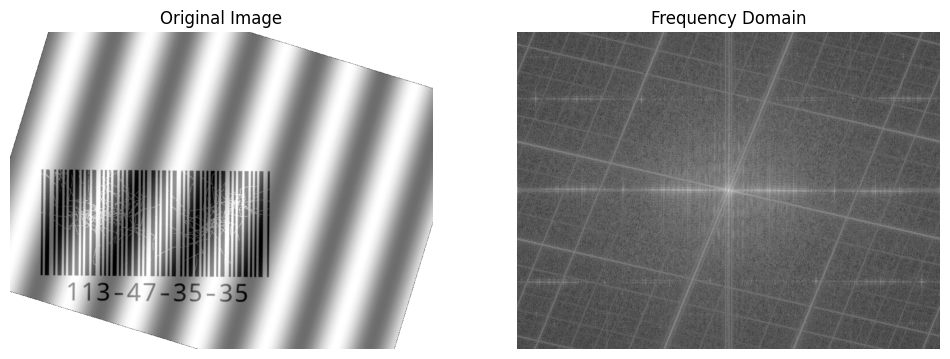

(True, 2)


In [141]:
image=cv2.imread("11 - bayza 5ales di bsara7a.jpg",cv2.IMREAD_GRAYSCALE)


angle = find_angle(image)

rotated_img=rotate_img(image,angle)

rotated_img=fill_corners(rotated_img)

show_frequency_domain(rotated_img)

print(detect_periodic_noise_lines_with_opencv(rotated_img,offset=2))


Top 10 most repeated angles:
Angle: 45.00 degrees, Count: 80
Angle: 152.00 degrees, Count: 78
Angle: 58.00 degrees, Count: 45
Angle: 65.00 degrees, Count: 42
Angle: 62.00 degrees, Count: 39
Angle: 64.00 degrees, Count: 39
Angle: 76.00 degrees, Count: 38
Angle: 71.00 degrees, Count: 38
Angle: 60.00 degrees, Count: 37
Angle: 68.00 degrees, Count: 37


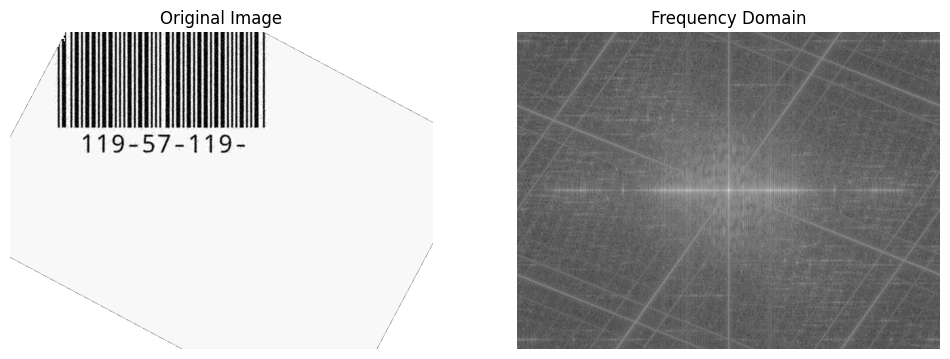

(False, 0)


In [ ]:
image=cv2.imread("09 - e3del el soora ya3ammm.jpg",cv2.IMREAD_GRAYSCALE)

angle = find_angle(image)

rotated_img=rotate_img(image,angle)

rotated_img=fill_corners(rotated_img)

show_frequency_domain(rotated_img)

print(detect_periodic_noise_lines(rotated_img,offset=2))

246


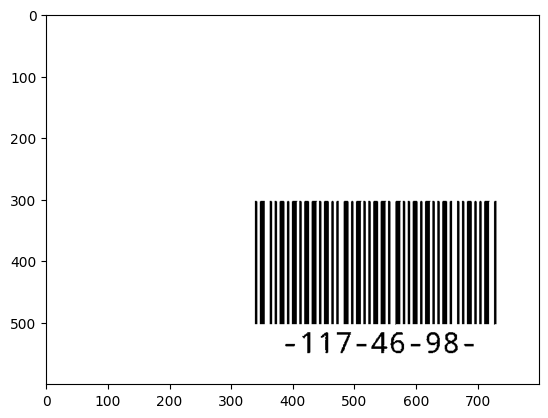

In [114]:




image=cv2.imread("06 - meen fata7 el nour 333eenaaayy.jpg",cv2.IMREAD_GRAYSCALE)

hist_counts, bin_edges, total_pixels=compute_histogram(image)

threshold=find_threshold_value(image)

print(threshold)

_,thresholded=cv2.threshold(image,threshold,255,cv2.THRESH_BINARY)

plt.imshow(thresholded,cmap='gray')



    


                                        BLUR DETECTION

The characteristic we found for detecting blur is the values we get from running a laplacian filter (2nd order derivative)
and analyzing the values.

The intuition behind this is that the 2nd order derivative gets the mesure of sharpness (quick changes)

In normal pictures (not blurred) the result should a wide range of values , both the high values of the strong edges and
the low values of the flat spaces

In blurred photos we wouldn't have that range of values

Soo in conclusion the variance of the result would be low.

So we can analyze the variance of the laplacian of our images and analyze what are the standard values of the barcodes variance



In [ ]:
def variance_of_laplacian(image):
	return cv2.Laplacian(image, cv2.CV_64F).var()

def detectBlur(image):
    
    var=variance_of_laplacian(image)
    if var<1500:
        return True
    else :
        return False


In [ ]:
for pic in picture_names:
    image=cv2.imread(pic,cv2.IMREAD_GRAYSCALE)

    var=variance_of_laplacian(image)

    print(var)

#intuition behind results

# first 3 pictures totally fine high variance values should be the standard

#4th low value compared expected as it is actually blurry

# 5th and 6th , it makes sense that they are very low values since they are very dark or very white so actually not a lot of variance here

#salt and pepper , very high variance ok

#compresso espresso low value compared to first 3 but not really low like the 4th which is logical since it is a bit blurry but not as much as the other one
#  picture 9 also it is a bittt blurry but not really so 2000 is expected
# kontraaaaast same issue as black or dark kinda good since kontraas and bluriness and brightness can be fixed by the thresholding
# 
# finallyyyy last one is a bit weird but we would detect periodic noise before checking the bluriness
# probably would work
 
#faa oul ya korkor en na2ena threshold 1500 baa monaseb

#then we can threshold to get a better looking picture with our kinda smart thresholding

4669.435829166667
4631.7931
4413.379930912149
253.431
15.635929166666667
12.337404166666667
77916.15300921956
1354.5365875
2273.8769912549283
1.2291666666666667
853.7488479790106


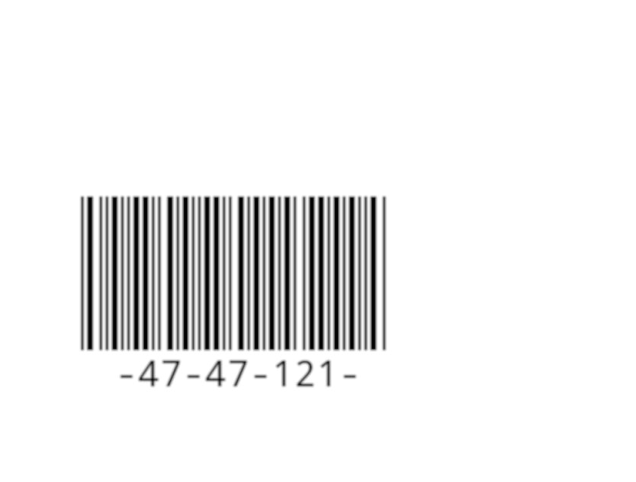

True


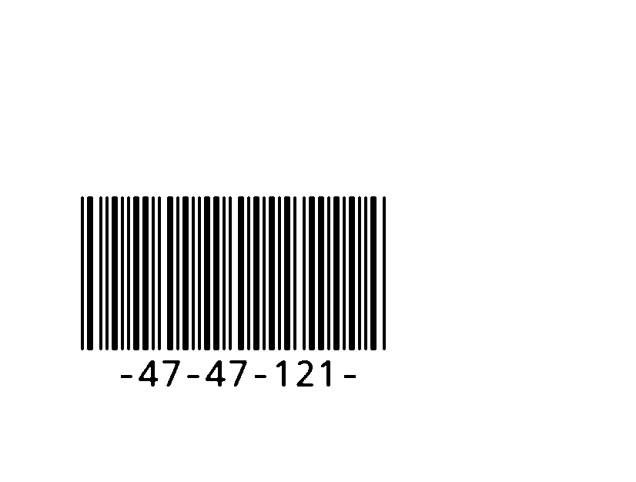

In [ ]:
image_blurred=cv2.imread("04 - fen el nadara.jpg",cv2.IMREAD_GRAYSCALE)

display_image(image_blurred)

print(detectBlur(image_blurred))

threshold=find_threshold_value(image_blurred)

_,image_not_blurred_anymore=cv2.threshold(image_blurred,threshold,255,cv2.THRESH_BINARY)

display_image(image_not_blurred_anymore)





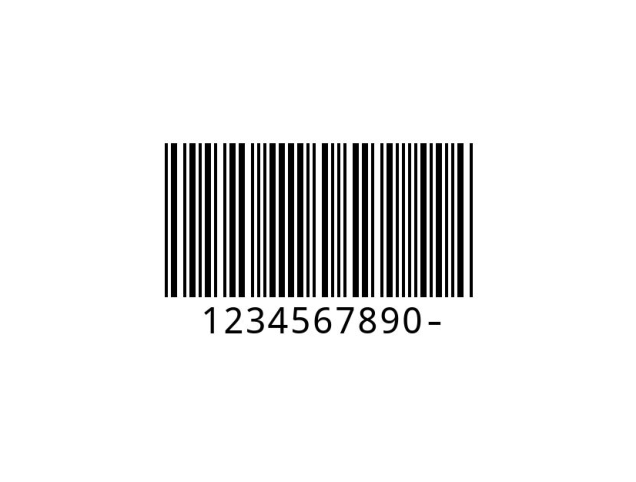

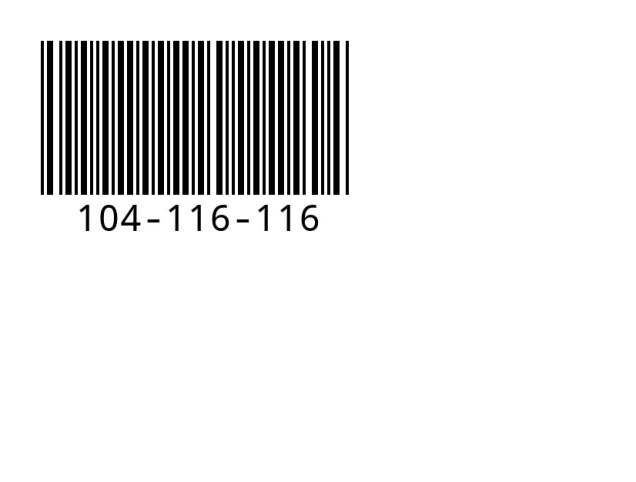

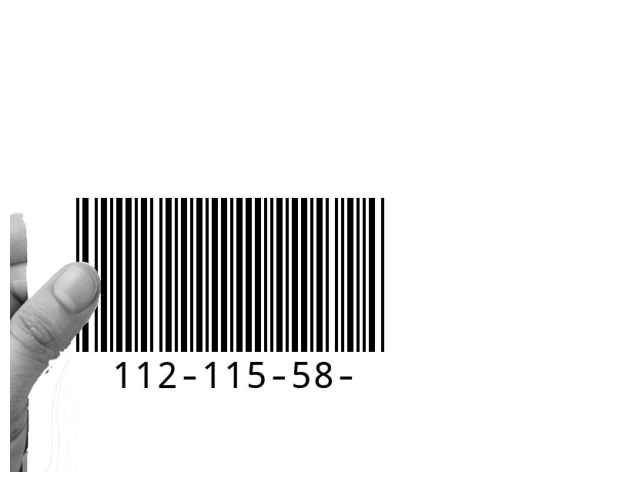

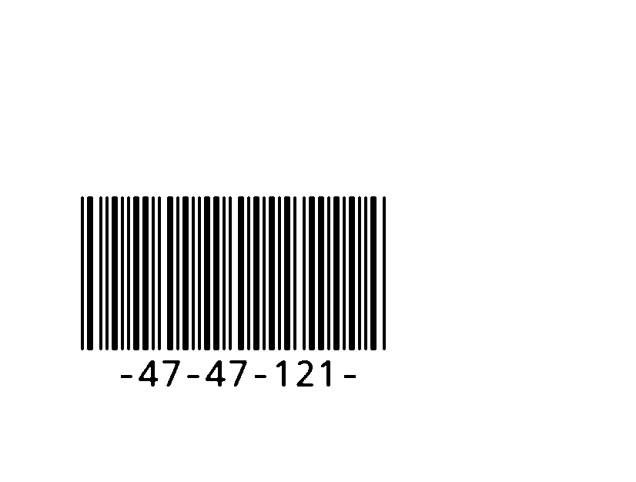

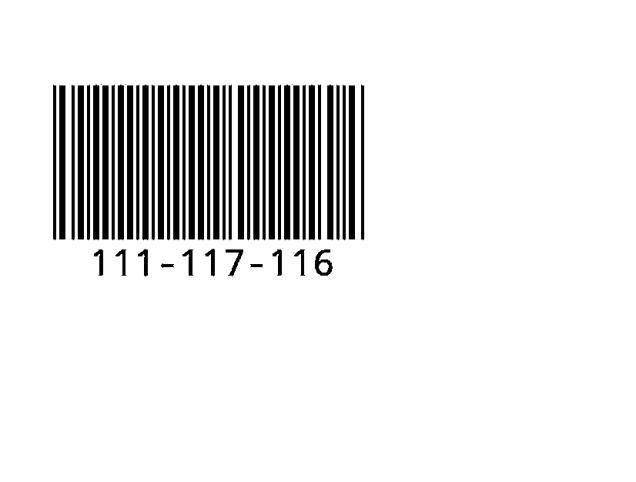

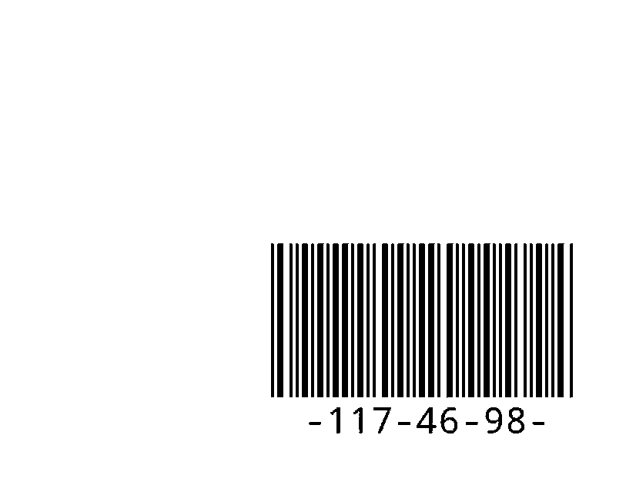

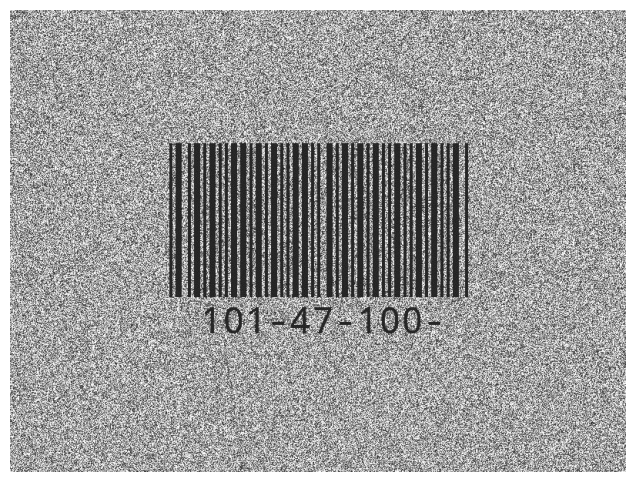

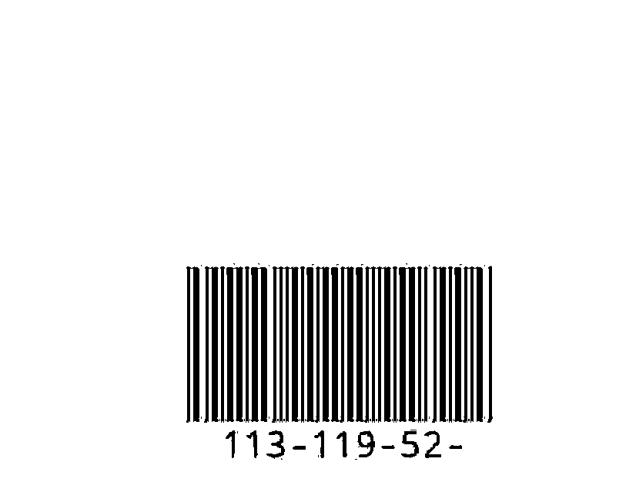

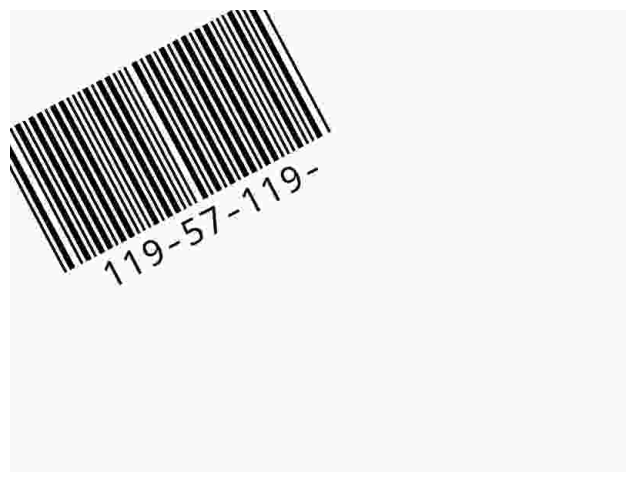

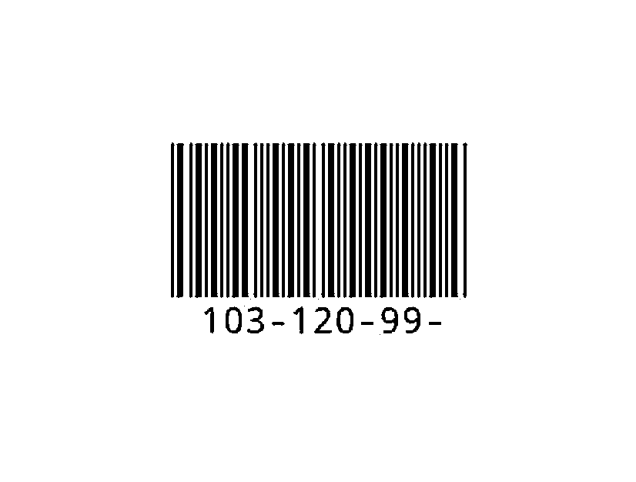

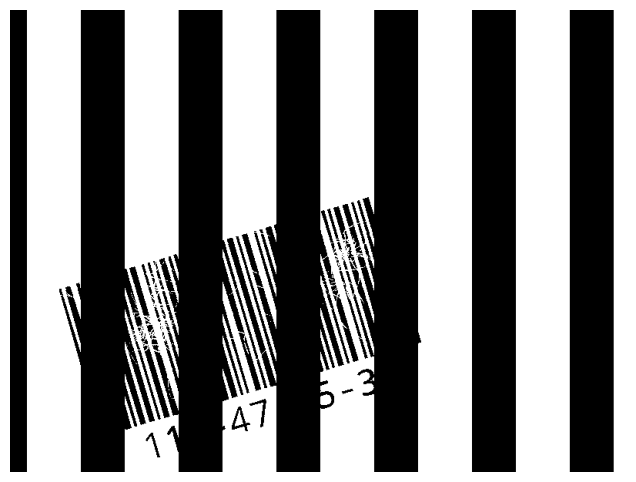

In [138]:
for pic in picture_names:
    image=cv2.imread(pic,cv2.IMREAD_GRAYSCALE)

    var=variance_of_laplacian(image)

    if var<2000:
        threshold=find_threshold_value(image)

        _,image=cv2.threshold(image,threshold,255,cv2.IMREAD_GRAYSCALE)

    display_image(image)

    cropped=crop_image_contour_sorry_kiwi(image)

    # pixels=get_mean_pixels(cropped,40)

    # get_code(pixels)
    decode_barcode



    

In [145]:
def detectBlur(image):


    var=variance_of_laplacian(image)

    if var<1500:
        return True
    else :
        return False


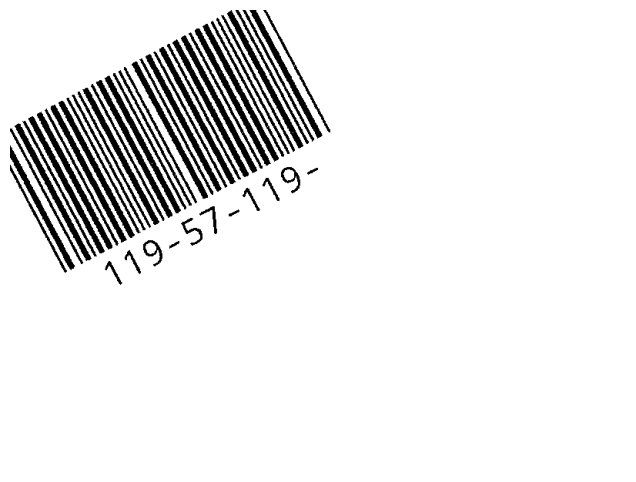

(False, 0)
(False, 0)
False
(False, 0)


In [151]:
image=cv2.imread("09 - e3del el soora ya3ammm.jpg",cv2.IMREAD_GRAYSCALE)

threshold=find_threshold_value(image)

_,t_image=cv2.threshold(image,threshold,255,cv2.THRESH_BINARY)

display_image(t_image)


print(detect_periodic_noise_lines_with_opencv(image,offset=2))
print(detect_periodic_noise_lines_with_opencv(t_image,offset=2))


print(detectBlur(t_image))

image2=cv2.imread("11 - bayza 5ales di bsara7a.jpg",cv2.IMREAD_GRAYSCALE)

print(detect_periodic_noise_lines_with_opencv(image2,offset=2))

For analysis purposes before we try to fix the pictures
Let's take a look at the difference between the very clean barcode picture and the one that has periodic noise
The original image should be the golden standard of how the barcodes should look like so it would be good to find a characteristic that is a metric of how it should look like

So after we look at both these pictures , in the original there exists a very clear horizontal sinc in the image, the most important aspect of the all the barcodes here , this sinc exists in all of them

Now for the one with periodic noise, we can see that there are other sincs other than the horizontal one (the barcode in this image is rotated so makes sense that the sincs are rotated but the central should be horizontal)

The sinc pattern other than the central doesn't exist in any of the other noisy picture like the one with the finger
so we can safely assume that the multiple sincs is resultant from the periodic noise, this will be important for detection later.






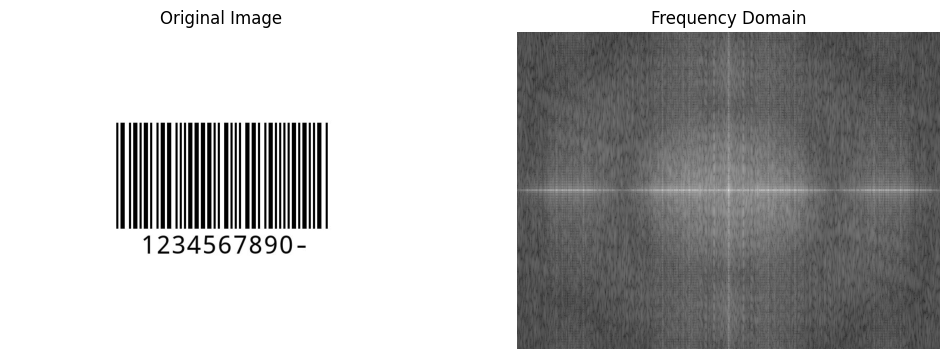

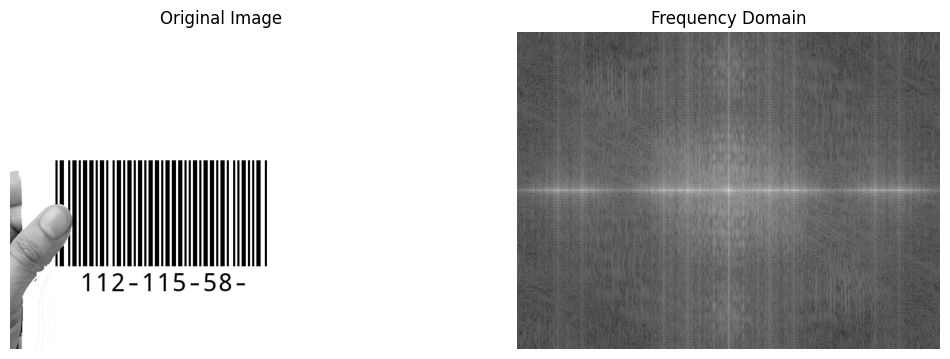

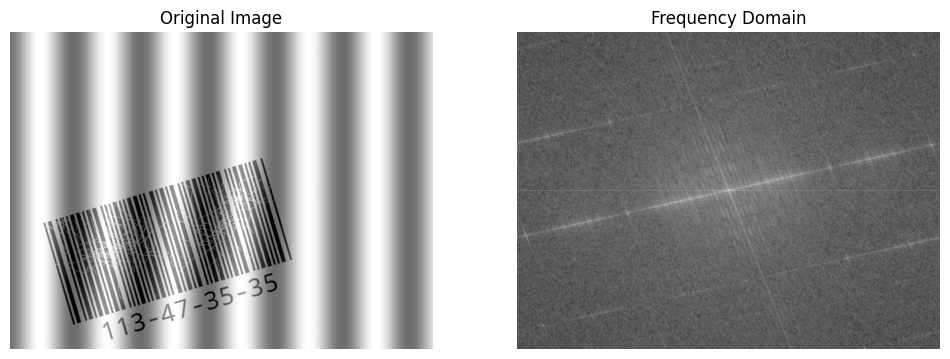

In [163]:
image=cv2.imread("01 - lol easy.jpg",cv2.IMREAD_GRAYSCALE)

image2=cv2.imread("11 - bayza 5ales di bsara7a.jpg",cv2.IMREAD_GRAYSCALE)

image3=cv2.imread("03 - eda ya3am ew3a soba3ak mathazarsh.jpg",cv2.IMREAD_GRAYSCALE)

show_frequency_domain(image)

show_frequency_domain(image3)


show_frequency_domain(image2)

To be able to rotate the barcodes and actually detect the angle of rotation it needs(maybe it doesn't need)

We detect the angles using hough lines, since when the image is hough-transformed we are detecting lines and angles

So we count the most dominant line angle in the find angle.

The results needed to be looked at for a while to check for patterns.

We found out that the image in need of rotation every time had 45 as its most common angle but this isn't the angle of rotation, the angle of rotation was actually the second most common.

For the images that don't need rotation they always had 0 as its most common angle which is a a logical result since we are counting the angles of the lines of the barcodes.



In [181]:
image_in_need_of_rotation=cv2.imread("09 - e3del el soora ya3ammm.jpg",cv2.IMREAD_GRAYSCALE)

angle1=find_angle(image_in_need_of_rotation)

another_image_in_need_of_rotation=cv2.imread("11 - bayza 5ales di bsara7a.jpg",cv2.IMREAD_GRAYSCALE)

angle2=find_angle(another_image_in_need_of_rotation)

image_not_in_need_of_rotation=cv2.imread("01 - lol easy.jpg",cv2.IMREAD_GRAYSCALE)

find_angle(image_not_in_need_of_rotation)


Top 5 most repeated angles:
Angle: 45.00 degrees, Count: 80
Angle: 152.00 degrees, Count: 78
Angle: 58.00 degrees, Count: 45
Angle: 65.00 degrees, Count: 42
Angle: 62.00 degrees, Count: 39

Top 5 most repeated angles:
Angle: 45.00 degrees, Count: 55
Angle: 163.00 degrees, Count: 53
Angle: 164.00 degrees, Count: 37
Angle: 58.00 degrees, Count: 27
Angle: 72.00 degrees, Count: 25

Top 5 most repeated angles:
Angle: 0.00 degrees, Count: 78
Angle: 45.00 degrees, Count: 4
Angle: 90.00 degrees, Count: 3
Angle: 58.00 degrees, Count: 2
Angle: 122.00 degrees, Count: 2


0.0

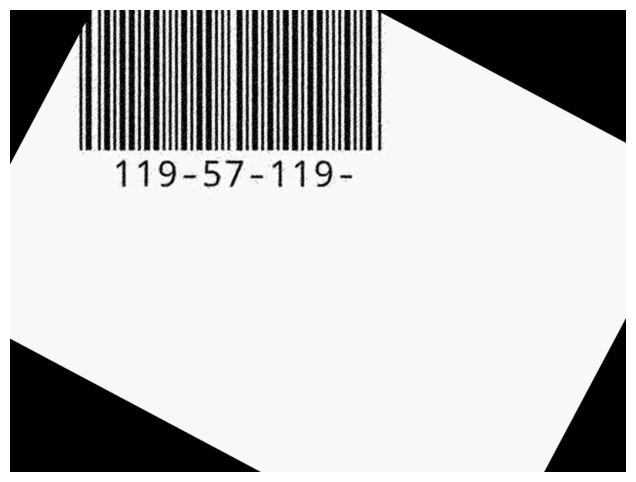

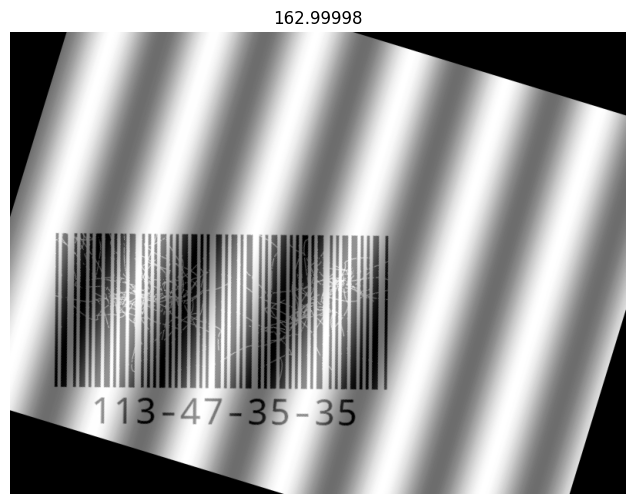

In [183]:
image_not_in_need_of_rotation_anymore=rotate_img(image_in_need_of_rotation,angle1)

display_image(image_not_in_need_of_rotation_anymore)


another_image_not_in_need_of_rotation_anymore=rotate_img(another_image_in_need_of_rotation,angle2)

display_image(another_image_not_in_need_of_rotation_anymore,angle2)

#since the angle of the image not in need of rotation is 0 so in a pipeline setting we find out that this isn't in need of rotation


Notice the corners but we got that covered we have a function that flood fills the corners

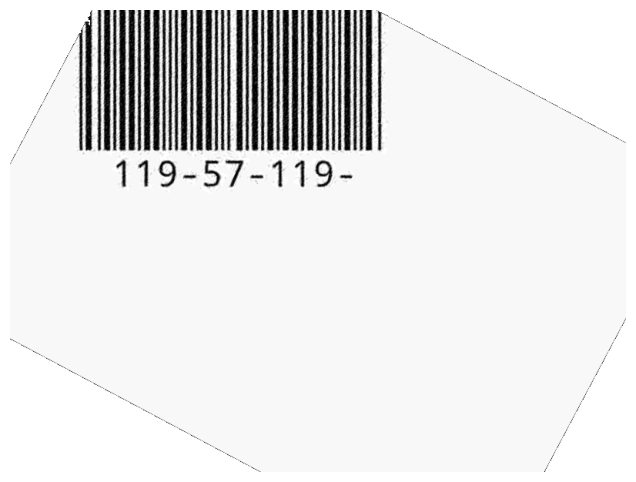

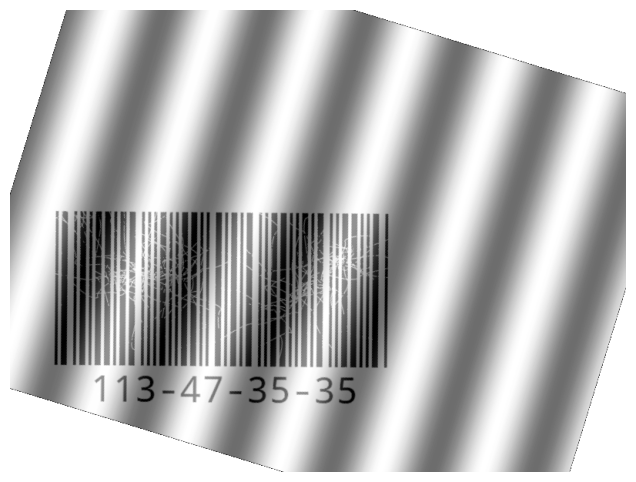

In [185]:
image_not_in_need_of_rotation_anymore=fill_corners(image_not_in_need_of_rotation_anymore)

display_image(image_not_in_need_of_rotation_anymore)

another_image_not_in_need_of_rotation_anymore=fill_corners(another_image_not_in_need_of_rotation_anymore)

display_image(another_image_not_in_need_of_rotation_anymore)

In [184]:

def fill_corners(rotated_img):
    # Make a copy to modify
    filled_image = rotated_img.copy()

    # Define flood fill parameters
    h, w = filled_image.shape
    flood_fill_color = 255  

    # Create a mask for flood fill (2 pixels larger than the image)
    mask = np.zeros((h + 2, w + 2), np.uint8)

   
    cv2.floodFill(filled_image, mask, seedPoint=(0, 0), newVal=flood_fill_color)  # Top-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, 0), newVal=flood_fill_color)  # Top-right corner
    cv2.floodFill(filled_image, mask, seedPoint=(0, h - 1), newVal=flood_fill_color)  # Bottom-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, h - 1), newVal=flood_fill_color)  # Bottom-right corner

    

    return filled_image

def rotate_img(img,angle):

    center = (img.shape[1] // 2, img.shape[0] // 2)

    rot_matrix = cv2.getRotationMatrix2D(center,-(180-angle) , 1.0)

    rotated_img = cv2.warpAffine(img, rot_matrix, (img.shape[1], img.shape[0]))

    return rotated_img


def find_angle(img_gray):

    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)
    
    edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    angles = []

    if lines is not None:
        for rho, theta in lines[:, 0]:
            angle = np.degrees(theta)  
            angles.append(angle)  
           # print(f"Detected angle: {angle}")
    if angles:
        
        angle_counts = Counter(angles)
        
        
        top_5_angles = angle_counts.most_common(10)
        
        
        print("\nTop 10 most repeated angles:")
        for angle, count in top_5_angles:
    
            print(f"Angle: {angle:.2f} degrees, Count: {count}")

    if top_5_angles[0][0] == 45.00:
        return top_5_angles[1][0]  # Return the second most common angle
    else:
        return top_5_angles[0][0]  # Return the most common angle
    

    

In [161]:
image3=cv2.imread("07 - mal7 w felfel.jpg",cv2.IMREAD_GRAYSCALE)



a,b,c=compute_histogram(image2)

print(detect_bright(a,b,c))

print(detect_dark(a,b,c))

print(detect_contrast(a,b,c))

False
False
False
